Using TensorFlow backend.


(50000, 28, 28) (50000,)


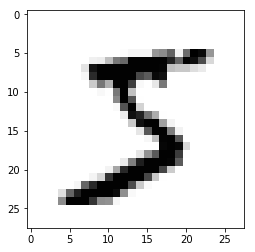

In [1]:
import sys
sys.path += ['week2']

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
from scipy.misc import imrotate, imresize

In [3]:
import tensorflow as tf
import numpy as np

## Preparation

Relaunch tensorboard, and import useful libraries.

In [ ]:
! killall tensorboard
import os
os.system("tensorboard --logdir=/tmp/tboard --port=7007 &");

import tensorflow as tf

import numpy as np

# Data inspection and preparation

We first take a look at the data, and prepare a version having just two classes.

In [ ]:
X_train.shape

In [ ]:
y_train[:10]

Let's create a flattened version of the data, because tensorflow has difficulty computing gradients across a reshape node.

In [4]:
rows = 28
cols = 28
classes = 10

s = tf.InteractiveSession()

with tf.variable_scope("1nn-reshaper"):
    # input shape
    x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    one_hot_y = tf.one_hot(y, 10)
    flat_x = tf.reshape(x, [-1, rows * cols])

X_train_flat, y_train_one_hot = s.run([flat_x, one_hot_y], feed_dict={
    x: X_train,
    y: y_train
})

## Single layer neural network

We first create a simple single layer neural network. We use a one_hot encode layer and a reshape layer to create a flat X. This will prove to be troublesome in the future, but it works for the first version. We use a softmax function to compute the predicted classes.

Also, for debugging, we create the `correct_prediction` and `accuracy` nodes, to avoid having to compute these metrics by hand after running the network.

In [5]:
rows = 28
cols = 28
classes = 10

tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn"):
    weights = tf.get_variable("weights", 
                              [rows * cols, classes],
                              initializer=tf.random_normal_initializer(mean=0, stddev=1e-3),
                              dtype=tf.float32)
    b = tf.get_variable("bias", [classes],
                    initializer=tf.random_uniform_initializer(minval=0, maxval=1e-3),
                    dtype=tf.float32)

    input_X = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    input_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    one_hot_y = tf.one_hot(input_y, classes)
    flat_X = tf.reshape(input_X, [-1, rows * cols])
    
    predicted_y = tf.nn.softmax(tf.matmul(flat_X, weights) + b)
    class_loss = -tf.log(predicted_y) * one_hot_y - tf.log(1 - predicted_y) * (1 - one_hot_y)
    loss = tf.reduce_mean(class_loss)
    
    correct_prediction = tf.equal(tf.cast(input_y, tf.int64), tf.argmax(predicted_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

Let's test that the weights get correctly initialized.

In [6]:
s.run(tf.global_variables_initializer())
print(s.run([weights, b]))

[array([[ -1.02057366e-03,  -4.27236548e-04,   2.47013268e-05, ...,
         -3.49555718e-04,  -3.32526426e-04,   1.42738491e-03],
       [  4.66067751e-04,  -8.86809372e-04,  -5.22999544e-05, ...,
         -1.69798057e-03,   7.26577418e-05,   2.62943620e-04],
       [ -1.15725701e-03,  -1.74877048e-03,   6.64400926e-04, ...,
          9.60978563e-04,  -1.56462414e-03,  -1.44472253e-03],
       ..., 
       [ -6.23423664e-04,   1.42920669e-03,   7.02040328e-04, ...,
         -1.31052430e-03,   1.44734676e-03,  -8.74818128e-04],
       [ -5.52055193e-04,  -9.15091252e-04,   1.31148787e-04, ...,
          6.25178160e-04,   8.09437421e-04,   1.61222037e-04],
       [  1.86423073e-03,   5.86324604e-04,   1.05774309e-03, ...,
          4.50900057e-04,   1.04007684e-03,   1.71791017e-03]], dtype=float32), array([ 0.00049114,  0.00032053,  0.00095181,  0.00077437,  0.00070904,
        0.00094271,  0.00029195,  0.0003054 ,  0.00092712,  0.00046623], dtype=float32)]


Let's test that the network computes different values correctly, or at least that they seem to be roughly correct. I struggled a bit with different data shapes and wrong initialization. I decided to keep this step to show what pains I went through.

In [7]:
s.run([weights, b, predicted_y, class_loss, one_hot_y, loss, correct_prediction, accuracy],
     {
         input_X: X_train[:3],
         input_y: y_train[:3]
     })

[array([[ -1.02057366e-03,  -4.27236548e-04,   2.47013268e-05, ...,
          -3.49555718e-04,  -3.32526426e-04,   1.42738491e-03],
        [  4.66067751e-04,  -8.86809372e-04,  -5.22999544e-05, ...,
          -1.69798057e-03,   7.26577418e-05,   2.62943620e-04],
        [ -1.15725701e-03,  -1.74877048e-03,   6.64400926e-04, ...,
           9.60978563e-04,  -1.56462414e-03,  -1.44472253e-03],
        ..., 
        [ -6.23423664e-04,   1.42920669e-03,   7.02040328e-04, ...,
          -1.31052430e-03,   1.44734676e-03,  -8.74818128e-04],
        [ -5.52055193e-04,  -9.15091252e-04,   1.31148787e-04, ...,
           6.25178160e-04,   8.09437421e-04,   1.61222037e-04],
        [  1.86423073e-03,   5.86324604e-04,   1.05774309e-03, ...,
           4.50900057e-04,   1.04007684e-03,   1.71791017e-03]], dtype=float32),
 array([ 0.00049114,  0.00032053,  0.00095181,  0.00077437,  0.00070904,
         0.00094271,  0.00029195,  0.0003054 ,  0.00092712,  0.00046623], dtype=float32),
 array([[ 0.10

Finally, compute accuracy metrics when training the network.

In [ ]:
s.run(tf.global_variables_initializer())

losses = []
test_accuracies = []
train_accuracies = []

for i in range(30):
    s.run(optimizer, {input_X: X_train, input_y: y_train})
    loss_i = s.run(loss,  {input_X: X_train, input_y: y_train})
    losses += [loss_i]
    train_accuracies += [s.run(accuracy, {input_X:X_train, input_y: y_train})]
    test_accuracies += [s.run(accuracy, {input_X:X_test, input_y: y_test})]


In [ ]:
plt.figure()
plt.plot(losses);
plt.plot(train_accuracies)
plt.plot(test_accuracies);
plt.legend(['loss', 'training accuracy', 'test accuracy'])


Next, we create a generator that will provide us with randomized minibatches, to do incremental training.

In [131]:
import random

class MiniBatchGenerator:
    def __init__(self, X, y, batch_size):
        self.X = X.copy()
        self.y = y.copy()
        self.batch_size = batch_size
        self.current_i = 0
        self.total_size = len(self.X)
        
        self.reshuffle()
        
    def reshuffle(self):        
        idxs = list(range(self.total_size))
        random.shuffle(idxs)
        self.idxs = np.array(idxs, dtype=np.int32)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        res_idxs = []
        
        end_i = self.current_i + self.batch_size
        
        if end_i > self.total_size:
            rem = end_i - self.total_size
            res_idxs = self.idxs[self.current_i:]
            self.reshuffle()
            res_idxs = np.append(res_idxs, self.idxs[:rem], axis=0)
            self.current_i = rem
        else:
            res_idxs = self.idxs[self.current_i:end_i]
            self.current_i = end_i

        return self.X[res_idxs], self.y[res_idxs]

In [132]:
def train_network(iterations=2000, batch_size=1000, X_train=X_train, y_train=y_train):
    s.run(tf.global_variables_initializer())

    batcher = MiniBatchGenerator(X_train, y_train, batch_size)
    print(X_train.shape)
    print(y_train.shape)

    losses = []
    batch_train_accuracies = []

    train_accuracies = []
    test_accuracies = []

    for i in range(iterations):
        X_batch, y_batch = batcher.next()

        loss_i, accuracy_i, optimizer_i = s.run([
            loss, accuracy, optimizer
        ],  {input_x: X_batch, 
                         label_y: y_batch})

        if i % 100 == 0:        
            losses += [loss_i]
            batch_train_accuracies += [accuracy_i]

#             accuracy_i = s.run(
#                 accuracy 
#             ,  {input_x: X_train, 
#                  label_y: y_train})
#             train_accuracies += [accuracy_i]

            test_accuracy_i = s.run(
                accuracy 
            ,  {input_x: X_test, 
                 label_y: y_test})
            test_accuracies += [test_accuracy_i]

            print("{} - loss: {}, train: {}, test: {}".format(i, loss_i, accuracy_i, test_accuracy_i))

    plt.figure()
#     plt.plot(losses);
#     plt.plot(batch_train_accuracies)
#     plt.plot(train_accuracies)
#     plt.plot(test_accuracies);
#     plt.legend(['loss', 'batch train accuracy', 'training accuracy', 'test accuracy'])

    plt.figure()
    plt.plot(batch_train_accuracies[-60:])
    plt.plot(test_accuracies[-60:]);
    plt.legend(['batch training accuracy', 'test accuracy'])

## Multilayer neural network

In this neural network, we use a second 50 neuron layer. The first layer has a sigmoid activation function.

In [10]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)

import tensorflow as tf

rows = 28
cols = 28
classes = 10

layer_cnt = 0

def add_layer(in_, size, output_f, sigma=1):
    global layer_cnt
    
    W2 = tf.get_variable("weights{}".format(layer_cnt),
                         [in_.shape[1], size],
                         initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                         dtype=tf.float32)
    b2 = tf.get_variable("bias{}".format(layer_cnt),
                         [size],
                         initializer=tf.zeros_initializer(),
                         dtype=tf.float32)

    y2 = output_f(tf.matmul(in_, W2) + b2)
    
    layer_cnt += 1
    return y2

hidden_size = 30

tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = 1

    # input layer
    y1 = add_layer(x, 100, tf.nn.sigmoid, sigma=sigma)
    y2 = add_layer(y1, 50, tf.nn.sigmoid, sigma=sigma)
    y3 = add_layer(y2, 50, tf.nn.sigmoid, sigma=sigma)
    y = add_layer(y3, 10, tf.nn.softmax, sigma=sigma)

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(2.).minimize(loss)
    
    s.run(tf.global_variables_initializer())



(50000, 28, 28) (50000,)


(50000, 28, 28)
(50000,)
0 - loss: 5.294643402099609, train: 0.10302000492811203, test: 0.10080000013113022
100 - loss: 0.6739616394042969, train: 0.7829201221466064, test: 0.781499981880188
200 - loss: 0.5038734078407288, train: 0.84934002161026, test: 0.847100019454956
300 - loss: 0.3965532183647156, train: 0.8803198933601379, test: 0.8729000687599182
400 - loss: 0.342928409576416, train: 0.8980399370193481, test: 0.8896000981330872
500 - loss: 0.2711547017097473, train: 0.9094399213790894, test: 0.8967001438140869
600 - loss: 0.2824562191963196, train: 0.9176399111747742, test: 0.9035000205039978
700 - loss: 0.2586315870285034, train: 0.9228998422622681, test: 0.9075000882148743
800 - loss: 0.2609403133392334, train: 0.9303198456764221, test: 0.9127001762390137
900 - loss: 0.19397962093353271, train: 0.9353997707366943, test: 0.9150000810623169
1000 - loss: 0.20724773406982422, train: 0.9402598738670349, test: 0.9198000431060791
1100 - loss: 0.20889964699745178, train: 0.94405984878

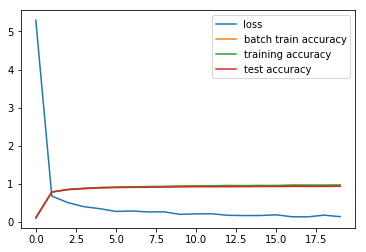

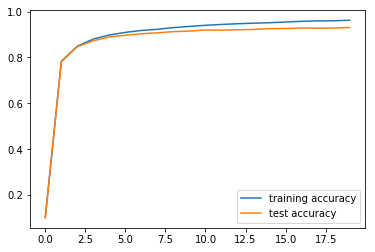

In [11]:
train_network()

In [142]:
expanded_X_train = []
expanded_y_train = []

def img_resize(img, percent):
    img_ = imresize(img, percent)
    offset = int((img_.shape[0] - 28) / 2)
    return img_[offset:offset+28, offset:offset+28]

for i in range(len(X_train)):
    img = X_train[i]
    img_class = y_train[i]

    expanded_X_train += [img]
    expanded_y_train += [img_class]

    for angle in [5, -5, 10, -10, -15, 15, -20, 20]:
#     for angle in [10, -10]:
        img_ = imrotate(img, angle) / 255.
        assert img_.shape[0] == 28
        expanded_X_train += [img_]
        expanded_y_train += [img_class]
    
    for scale in [120, 110]:
        img_ = img_resize(img, scale) / 255.
        assert img_.shape[0] == 28
        expanded_X_train += [img_]
        expanded_y_train += [img_class]
    
expanded_X_train = np.array(expanded_X_train)
expanded_y_train = np.array(expanded_y_train)


In [144]:
tf.reset_default_graph()
s = tf.InteractiveSession()

def add_layer_with_loss(in_, size, output_f, sigma=1):
    global layer_cnt
    
    W2 = tf.get_variable("weights{}".format(layer_cnt),
                         [in_.shape[1], size],
                         initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                         dtype=tf.float32)
    b2 = tf.get_variable("bias{}".format(layer_cnt),
                         [size],
                         initializer=tf.zeros_initializer(),
                         dtype=tf.float32)

    y2 = output_f(tf.matmul(in_, W2) + b2)
    
    loss = tf.norm(W2, ord=2)
#     loss = tf.reduce_sum(tf.sqrt(tf.tensordot(tf.squeeze(W2), tf.squeeze(W2), 1)))
#     loss += tf.reduce_sum(tf.sqrt(tf.tensordot(b2, b2, 1)))
    
    layer_cnt += 1
    return y2, loss


with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = 0.1
    print("sigma", sigma)
  
    # input layer
    loss_lambda = 0.01
    
    y1, loss_ = add_layer_with_loss(x, 100, tf.nn.relu, sigma=sigma)
    loss = loss_lambda * loss_
    y3, loss_ = add_layer_with_loss(y1, 50, tf.nn.relu, sigma=sigma)
    loss += loss_lambda * loss_
    y, loss_ = add_layer_with_loss(y3, 10, tf.nn.softmax, sigma=sigma)
    loss += loss_lambda * loss_

    loss += tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = .8
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.96, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#     optimizer = tf.train.GradientDescentOptimizer(2.).minimize(loss)

    
    s.run(tf.global_variables_initializer())

train_network(iterations=5000, batch_size=1000, X_train=X_train, y_train=y_train)

sigma 0.1
(50000, 28, 28)
(50000,)
0 - loss: 2.718897581100464, train: 0.07100000232458115, test: 0.2157999873161316
100 - loss: 0.645745038986206, train: 0.9240000247955322, test: 0.9271001219749451
200 - loss: 0.6266799569129944, train: 0.9220000505447388, test: 0.9482001066207886
300 - loss: 0.5100219249725342, train: 0.9650000333786011, test: 0.9590001106262207


KeyboardInterrupt: 

In [ ]:
train_network(iterations=5000, batch_size=1000, X_train=expanded_X_train, y_train=expanded_y_train)

(550000, 28, 28)
(550000,)
0 - loss: 2.69490647315979, train: 0.07600000500679016, test: 0.2726999521255493
100 - loss: 0.7746925354003906, train: 0.8900001049041748, test: 0.9070001244544983
200 - loss: 0.6733514070510864, train: 0.9190000295639038, test: 0.9385001063346863
300 - loss: 0.6517444849014282, train: 0.9240000247955322, test: 0.9542001485824585
400 - loss: 0.5867795944213867, train: 0.9460000395774841, test: 0.9612001180648804
500 - loss: 0.5914017558097839, train: 0.9380000829696655, test: 0.9641001224517822
600 - loss: 0.5276877284049988, train: 0.9569999575614929, test: 0.9647001028060913
700 - loss: 0.5461990833282471, train: 0.9460000395774841, test: 0.9686000347137451
800 - loss: 0.7036571502685547, train: 0.8999999761581421, test: 0.8885000348091125
900 - loss: 0.46899890899658203, train: 0.9700000286102295, test: 0.9717000722885132
1000 - loss: 0.4725476801395416, train: 0.9630000591278076, test: 0.9724001288414001
1100 - loss: 0.46233031153678894, train: 0.9729999

(350000, 28, 28)
(350000,)
0 - loss: 3.5045151710510254, train: 0.15700000524520874, test: 0.24939997494220734
100 - loss: 1.6753380298614502, train: 0.8329999446868896, test: 0.8565000295639038
200 - loss: 1.3664897680282593, train: 0.906000018119812, test: 0.9259001016616821
300 - loss: 1.2018520832061768, train: 0.9300000071525574, test: 0.9474000930786133
400 - loss: 1.0768394470214844, train: 0.9420000910758972, test: 0.9529001712799072
500 - loss: 1.0233819484710693, train: 0.9500000476837158, test: 0.954500138759613
600 - loss: 0.9942128658294678, train: 0.9450000524520874, test: 0.9602000713348389
700 - loss: 0.9203286170959473, train: 0.958000123500824, test: 0.96260005235672
800 - loss: 0.9133054614067078, train: 0.9399999976158142, test: 0.9555001854896545
900 - loss: 0.83608078956604, train: 0.956000030040741, test: 0.9638000726699829


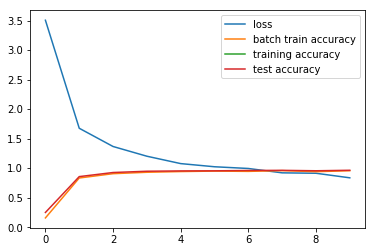

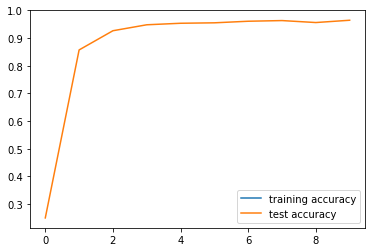

In [126]:
%lprun -f train_network train_network(iterations=1000, batch_size=1000, X_train=expanded_X_train, y_train=expanded_y_train)

In [98]:

%load_ext line_profiler

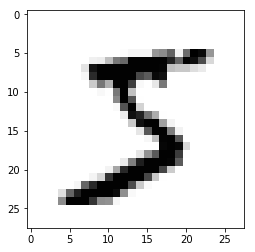

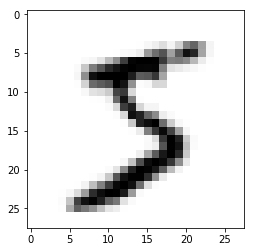

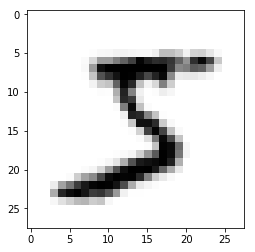

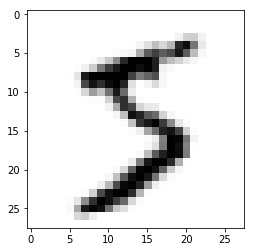

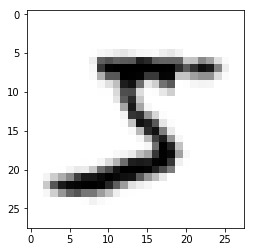

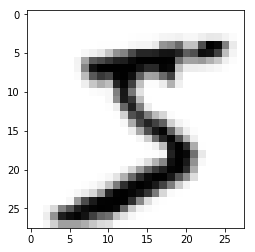

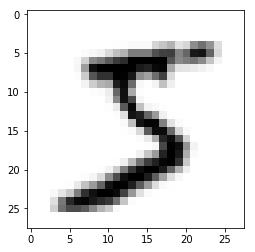

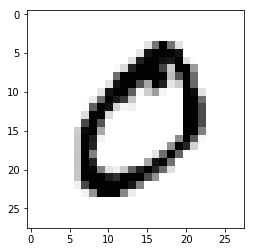

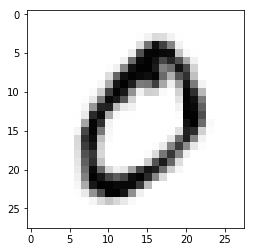

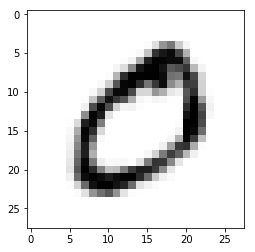

In [95]:
for i in range(10):
    plt.figure()
    plt.imshow(expanded_X_train[i], cmap="Greys");